In [1]:
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20 ,6)
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error

## ローレンツ96のモデルを作る
6h = 0.05 step

In [2]:
def l96_model(x, t):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

def l96_step(x, step):
    t = np.arange(0.0, step+0.01, 0.01)
    x = odeint(l96_model, x, t)
    return x[1:]

In [3]:
N = 40
F = 8
step = 0.05
x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable

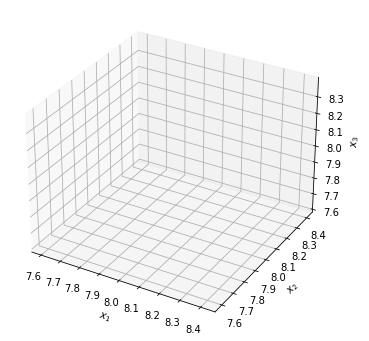

In [4]:
x = l96_step(x0, 0.01)
# Plot the first three variables
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()


### 2年分の積分
2 * 365 * 4 * 0.05 = 146.0 step必要

In [5]:
x_one = l96_step(x0, 73.0)  # spin up
x = l96_step(x_one[-1], 73.0)
data = x[::5]
print(data.shape)

(1460, 40)


In [6]:
np.savetxt("gendata.txt", data)

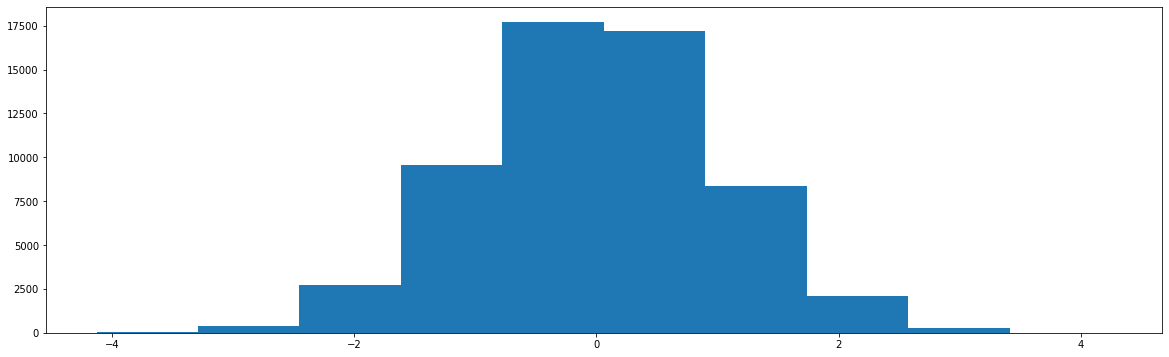

In [7]:
random_ls = np.random.randn(data.shape[0], x[::5].shape[1])
plt.hist(np.ravel(random_ls))
plt.show()

In [8]:
datawithnoise = data + random_ls
np.savetxt("datawithnoise.txt", datawithnoise)

## データ同化システムの構築
カルマンフィルタ

In [9]:
def kf_forecast(xa, pa,R,H, param=1.0):
    #pa = pa * 1.1
    step = 0.01
    xf = l96_step(xa, 0.01)[-1]
    def getM(xc):
        m = []
        delta = 0.001
        for i in range(xc.shape[0]):
            b = np.zeros_like(xc)
            b[i] += delta
            m.append(l96_step(xc + b, step)[-1] - l96_step(xc, step)[-1])
        return np.array(m).T /delta
    M = getM(xa)
    pf = M @ pa @ M.T
    return xf, pf * param

In [10]:
# 初期値
pa = np.eye(N) * 25
rs = step * int(np.random.randint(1, 1000))
xa = l96_step(x_one[-1], rs)[-1]
R = np.eye(N)
I = np.eye(N)
Z = np.zeros_like(I)

In [11]:
xferror_before_assim =[]
xferror_after_assim = []
trpa = []
yrmse = []
for  i in tqdm(range(300 * 5)):
    if i % 5 == 0:
        H = I
    else:
        H = Z
        xa = l96_step(xa, 0.01)[-1]
        continue
    yt = data[i//5]
    y = datawithnoise[i//5]
    xf, pf = kf_forecast(xa, pa,R,H)
    xferror_before_assim.append( np.sqrt(mean_squared_error(yt,  xf)))
    K = pf @ H.T @ np.linalg.inv(H@ pf @ H.T + R)
    xa = xf + K @ (y - H @ xf)
    pa = (np.eye(N)- K @ H )@ pf
    xferror_after_assim.append( np.sqrt(mean_squared_error(yt,  xa)))
    yrmse.append( np.sqrt(mean_squared_error(yt,  y)))
    trpa.append(np.sqrt(np.trace(pa)/N))

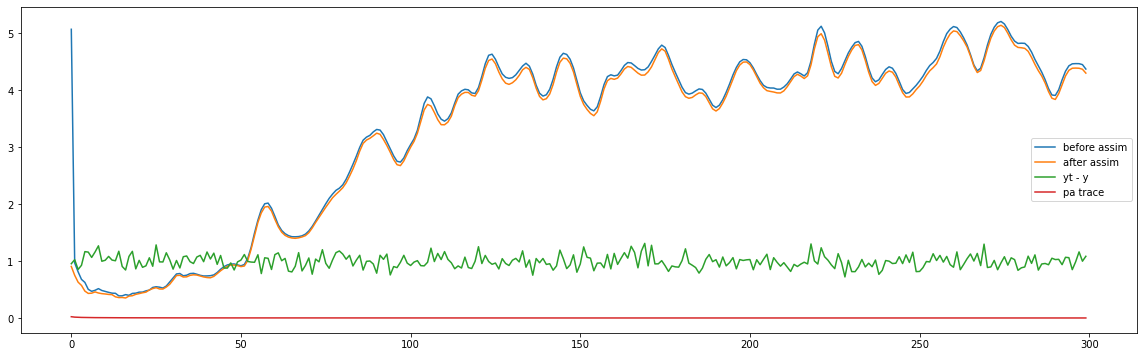

In [12]:
plt.plot(xferror_before_assim, label="before assim")
plt.plot(xferror_after_assim, label="after assim")
plt.plot(yrmse, label="yt - y")
plt.plot(np.array(trpa) / N, label="pa trace")
plt.legend()
plt.savefig('kf.png')

これ以降が違う

### 誤差共分散膨張

In [17]:
# 初期値
pa = np.eye(N) * 25
rs = step * int(np.random.randint(1, 1000))
xa = l96_step(x_one[-1], rs)[-1]
R = np.eye(N)
I = np.eye(N)
Z = np.zeros_like(I)

In [18]:
xferror_before_assim =[]
xferror_after_assim = []
trpa = []
yrmse = []
for  i in tqdm(range(1200 * 5)):
    if i % 5 == 0:
        H = I
    else:
        H = Z
        xa = l96_step(xa, 0.01)[-1]
        continue
    yt = data[i//5]
    y = datawithnoise[i//5]
    xf, pf = kf_forecast(xa, pa,R,H,1.1)
    xferror_before_assim.append( np.sqrt(mean_squared_error(yt,  xf)))
    K = pf @ H.T @ np.linalg.inv(H@ pf @ H.T + R)
    xa = xf + K @ (y - H @ xf)
    pa = (np.eye(N)- K @ H )@ pf
    xferror_after_assim.append( np.sqrt(mean_squared_error(yt,  xa)))
    yrmse.append( np.sqrt(mean_squared_error(yt,  y)))
    trpa.append(np.sqrt(np.trace(pa)/N))

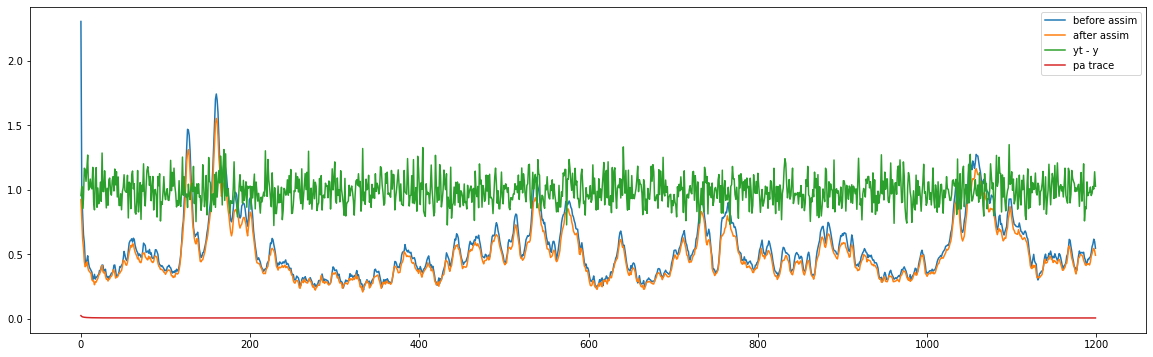

In [19]:
plt.plot(xferror_before_assim, label="before assim")
plt.plot(xferror_after_assim, label="after assim")
plt.plot(yrmse, label="yt - y")
plt.plot(np.array(trpa) / N, label="pa trace")
plt.legend()
plt.savefig('kfwinf.png')

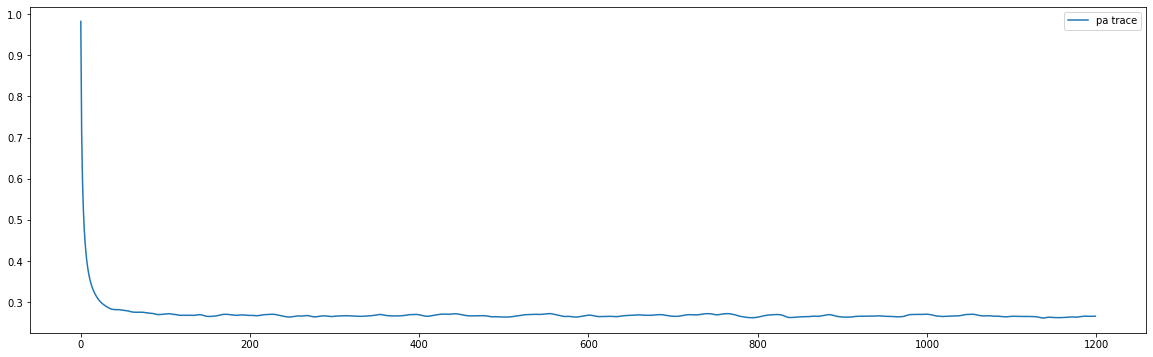

In [20]:
plt.plot(np.array(trpa), label="pa trace")
plt.legend()
plt.show()

### 三次元変分法

In [82]:
def henbun_forecast(xa, pa):
    xf = l96_step(xa, 0.01)[-1]
    return xf, pa

In [83]:
# 初期値
pa = np.eye(N) * 25
rs = step * int(np.random.randint(1, 1000))
xa = l96_step(x_one[-1], rs)[-1]
R = np.eye(N)
H = np.eye(N)

In [84]:
xferror_before_assim =[]
xferror_after_assim = []
trpa = []
yrmse = []
for  i in tqdm(range(300 * 5)):
    if i % 5 == 0:
        H = I
    else:
        H = Z
        xa = l96_step(xa, 0.01)[-1]
        continue
    yt = data[i//5]
    y = datawithnoise[i//5]
    xf, pf = henbun_forecast(xa, pa)
    xferror_before_assim.append( np.sqrt(mean_squared_error(yt,  xf)))
    K = pf @ H.T @ np.linalg.inv(H@ pf @ H.T + R)
    xa = xf + K @ (y - H @ xf)
    xferror_after_assim.append( np.sqrt(mean_squared_error(yt,  xa)))
    yrmse.append( np.sqrt(mean_squared_error(yt,  y)))
    trpa.append(np.sqrt(np.trace(pa)/N))

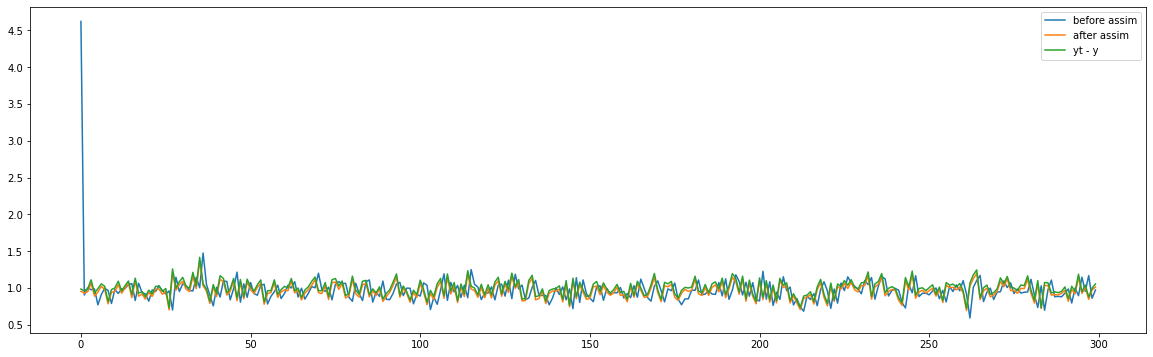

In [85]:
plt.plot(xferror_before_assim, label="before assim")
plt.plot(xferror_after_assim, label="after assim")
plt.plot(yrmse, label="yt - y")
plt.legend()
plt.savefig('3henbun.png')